# Basketball Hall of Fame Predictions

#### Overview

This notebook shows the model selection and evaluation process for estimating players' probabilities of making the basketball hall of fame using their career stats and accomplishments.

#### Data

The data was scraped from basketball-reference.com and preprocessed in the `process.py` script. Some of the data was scraped using `basketball_reference_web_scraper` written by [@jaebradley](https://github.com/jaebradley).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Read in dataset
data = pd.read_csv("nba_data/merged.csv").set_index("id")

Since these are stats that we may want examine later, we'll just calculate them at the start.

In [3]:
data["ppg"] = data.points / data.games_played
data["ppg_playoffs"] = data.points_playoffs / data.games_played_playoffs
data["rpg"] = data["total_rebounds"] / data["games_played"]

data.fillna(0, inplace=True)

Since possesions weren't tracked in the early NBA, we'll just replace the missing values with the median.

In [4]:
data["usage_percentage"] = data["usage_percentage"].replace(0, data["usage_percentage"].median())

In [5]:
data.usage_percentage

id
abdulka01    13.055204
jordami01    33.176952
russebi01    19.697114
bryanko01    31.959235
jamesle01    31.535358
               ...    
wedmasc01    13.313902
leeda02      20.540999
finlemi01    21.701022
brianfr01    19.697114
smithph01    13.547246
Name: usage_percentage, Length: 251, dtype: float64

In [6]:
data.rename({"Championships_playoffs": "Championships"}, axis=1, inplace=True)

In [7]:
data["Championships"]

id
abdulka01     6.0
jordami01     6.0
russebi01    11.0
bryanko01     5.0
jamesle01     3.0
             ... 
wedmasc01     2.0
leeda02       1.0
finlemi01     1.0
brianfr01     0.0
smithph01     1.0
Name: Championships, Length: 251, dtype: float64

### Train/Val/Test Split

Because in real life, predictions would be made in a different time period from the training set, our test and validation sets should reflect that. We also will make the test set include players who retired after 2005 so that we can compare with Basketball-Reference's model, which only includes players who retired by 2005.

In [8]:
eligible = data[data["LastYear"] <= 2016]
ineligible = data[data["LastYear"] > 2016]

In [9]:
train = eligible[eligible["LastYear"] <= 1998]
valid = eligible[(eligible["LastYear"] <= 2005) & 
                 (eligible["LastYear"] > 1998)]
test = eligible[eligible["LastYear"] > 2005]

In [10]:
print(train.shape)
print(valid.shape)
print(test.shape)

(141, 74)
(30, 74)
(35, 74)


Since our datasets are very small, we will choose simply models to avoid overfitting. And we'll also have to choose a few carefully selected features.

In [11]:
print(train[train["hof"] == True].shape)
print(train[train["hof"] == False].shape)

(91, 74)
(50, 74)


In [12]:
#Duplicate the rows of non-hall of fame players to make the dataset more balanced
train = train.append(train[train["hof"] == False])

In [13]:
train.columns

Index(['Name', 'Probability', 'LastYear', 'hof', 'League_mvp', 'Count_mvp',
       'Count_dpoy', 'All_stars', 'Count_finals_mvp', 'Unnamed: 0_playoffs',
       'assists_playoffs', 'attempted_field_goals_playoffs',
       'attempted_free_throws_playoffs',
       'attempted_three_point_field_goals_playoffs', 'blocks_playoffs',
       'defensive_rebounds_playoffs', 'games_played_playoffs',
       'games_started_playoffs', 'made_field_goals_playoffs',
       'made_free_throws_playoffs', 'made_three_point_field_goals_playoffs',
       'minutes_played_playoffs', 'offensive_rebounds_playoffs',
       'personal_fouls_playoffs', 'points_playoffs', 'steals_playoffs',
       'total_rebounds_playoffs', 'turnovers_playoffs', 'Championships',
       'Unnamed: 0', 'assists', 'attempted_field_goals',
       'attempted_free_throws', 'attempted_three_point_field_goals', 'blocks',
       'defensive_rebounds', 'games_played', 'games_started',
       'made_field_goals', 'made_free_throws', 'made_three_poin

In order to make it simpler for us to pick our features, we narrowed the field down to some that we feel are most plausibly very predictive. If we had kept all of the potential features, it would not only be confusu]ing for us, but it would also make it more difficult for our models to learn effectively. Especially for such a small dataset.

In [14]:
features = ["Count_mvp", "Count_dpoy", "All_stars", "Count_finals_mvp",
          "assists_playoffs", "games_started_playoffs",
           "minutes_played_playoffs", "points_playoffs",
          "total_rebounds_playoffs", "Championships",
          "assists", "games_started", "games_played", "minutes_played",
          "points", "total_rebounds", "box_plus_minus", "player_efficiency_rating",
          "value_over_replacement_player", "win_shares", "win_shares_per_48_minutes",
          'peak_win_shares', 'peak_value_over_replacement_player', 
           'ppg', 'ppg_playoffs', 'rpg']

len(features)

26

In [15]:
X_trn = train[features]
y_trn = train["hof"]

X_val = valid[features]
y_val = valid["hof"]

### Logistic Regression

The first model that we'll try will be a logistic regression model. This is a good first choice because it's a simple algorithm, meaning that it will be less likely to overfit than a more complex one. It also has a probabilistic interpretation which is important for our needs.

We will use Brier Score as our metric. We're using this metric because it heavily penalizes large errors, and we don't want any of our final probabilities to be very far from the truth.

We also normalize our features using StandardScaler to make it easier for the logistic regression to learn.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.feature_selection import RFE
from sklearn.base import clone

In [17]:
def print_metrics(model, features):
    train_acc = accuracy_score(model.predict(X_trn[features]), y_trn)
    valid_acc = accuracy_score(model.predict(X_val[features]), y_val)
    
    train_loss = brier_score_loss(y_trn, model.predict_proba(X_trn[features])[:, 1])
    valid_loss = brier_score_loss(y_val, model.predict_proba(X_val[features])[:, 1])
    
    if hasattr(model, "oob_score_"):
        oob_score = model.oob_score_
    else:
        oob_score = ""
    
    print(train_acc, valid_acc, oob_score, train_loss, valid_loss)

In [18]:
lr_pipe = make_pipeline(StandardScaler(),
                        LogisticRegression())


lr_pipe.fit(X_trn, y_trn)
print_metrics(lr_pipe, features)

0.8795811518324608 0.8666666666666667  0.09101207006529978 0.12752371995635275


To select features for out logistic regression, we use sklearn's recursive feature elimination (RFE) which fits our model and removes a features on each step based on the coefficients of the previous step.

In [19]:
min_loss = 1
best_selector = None

#Loop over all possible number of features to get the right amount
for i in range(1, 27):
    rfe_selector = RFE(estimator=LogisticRegression(max_iter=150), n_features_to_select=i)

    rfe_pipe = make_pipeline(StandardScaler(),
                             rfe_selector)
    
    rfe_pipe.fit(X_trn[features], y_trn)
    loss = brier_score_loss(y_val, rfe_pipe.predict_proba(X_val)[:, 1])
    #print(loss)
    
    if loss < min_loss:
        min_loss = loss
        best_selector = clone(rfe_selector)

rfe_pipe = make_pipeline(StandardScaler(),
                        best_selector)

rfe_pipe.fit(X_trn, y_trn)
rfe_support = best_selector.get_support()
rfe_features = X_trn.loc[:, rfe_support].columns

print(str(len(rfe_features)), 'selected features')
print(rfe_features.tolist())
print_metrics(rfe_pipe, features)

6 selected features
['Count_mvp', 'All_stars', 'Championships', 'box_plus_minus', 'value_over_replacement_player', 'ppg']
0.8272251308900523 0.9  0.10711748964899732 0.0705776399962272


In [41]:
logit = LogisticRegression()
lr_pipe = make_pipeline(StandardScaler(),
                       logit)

lr_pipe.fit(X_trn[rfe_features], y_trn)

#Show the coefficients of our logistic regression model 
pd.DataFrame({"Coefficients": logit.coef_.reshape((-1))}, index=rfe_features)

,Coefficients
Count_mvp,1.569915
All_stars,2.117843
Championships,1.551612
box_plus_minus,1.191951
value_over_replacement_player,-1.241967
ppg,0.437403


While checking out the coefficients of our model, we've found something unusual which is that the coefficient of value_over_replacement_player is negative. This is surprising because this is a player metric which should be higher the better a player is. The negative coefficient is almost certainly a result of colinearity with some other feature. So we'll just eliminate it from the model.

Note: It seems like our model is performing better on the validation set than on the training set, which is also unusual. But this is probably due to the small size of the validation set.

In [42]:
rfe_features_keep = ['Count_mvp', 'All_stars', 'Championships', 'box_plus_minus', 'ppg']
lr_pipe.fit(X_trn[rfe_features].drop("value_over_replacement_player", axis=1), y_trn)
pd.DataFrame(logit.coef_.reshape((-1, 1)), index=rfe_features_keep)
print_metrics(lr_pipe, rfe_features_keep)

pd.DataFrame({"Coefficients": logit.coef_.reshape((-1))}, index=rfe_features_keep)

0.8272251308900523 0.9  0.1148539455765552 0.07083869752849309


,Coefficients
Count_mvp,1.681519
All_stars,2.267450
Championships,1.590180
box_plus_minus,0.114319
ppg,0.228630


Now we'll try out one more type of model, a random forest. This slgorithm also doesn't tend to overfit very much, which makes it another good choice.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [23]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
rf = RandomForestClassifier(n_estimators=100, max_depth=6,
                            max_features=0.5,
                            n_jobs=-1, oob_score=True)
rf.fit(X_trn, y_trn)

print_metrics(rf, features)

0.9790575916230366 0.8666666666666667 0.8324607329842932 0.028987174306524956 0.11485165874072514


In [25]:
min_loss = 1
best_selector = None

#Loop over all possible number of features to get the right amount
for i in range(5, 6):
    rf = RandomForestClassifier(max_depth=7, max_features=0.5,
                                random_state=7)
    
    rf_selector = SelectFromModel(rf, max_features=i)
    rf_selector.fit(X_trn, y_trn)
    
    rf_support = rf_selector.get_support()
    rf_features = X_trn.loc[:, rf_support].columns

    rf.fit(X_trn[rf_features], y_trn)
    
    loss = brier_score_loss(y_val, rf.predict_proba(X_val[rf_features])[:, 1])
    #print(loss)
    
    if loss < min_loss:
        min_loss = loss
        best_features = rf_features


rf_features = best_features
rf.fit(X_trn[rf_features], y_trn)

print(str(len(rf_features)), 'selected features')
print(rf_features.tolist())
print_metrics(rf, rf_features)

5 selected features
['All_stars', 'Championships', 'player_efficiency_rating', 'win_shares', 'ppg']
0.9790575916230366 0.8666666666666667  0.029356830069540672 0.08266228037366541


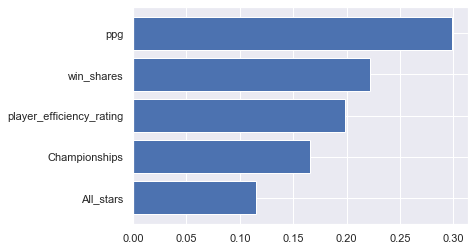

In [26]:
index = np.argsort(rf.feature_importances_)
features = X_trn.columns[index]

plt.barh(width=rf.feature_importances_[index], y=best_features);

As a sanity check, we create partial dependence plots for each of our predictor variables to see if we get positive relationships between each of our features and our target.

In [27]:
from pdpbox import pdp, get_dataset, info_plots

In [28]:
def plot_pdp(model, feat):
    pdp_fare = pdp.pdp_isolate(
        model=model, dataset=X_trn, model_features=best_features, feature=feat
    )
    
    fig, axes = pdp.pdp_plot(
        pdp_fare, feat, frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True
    )

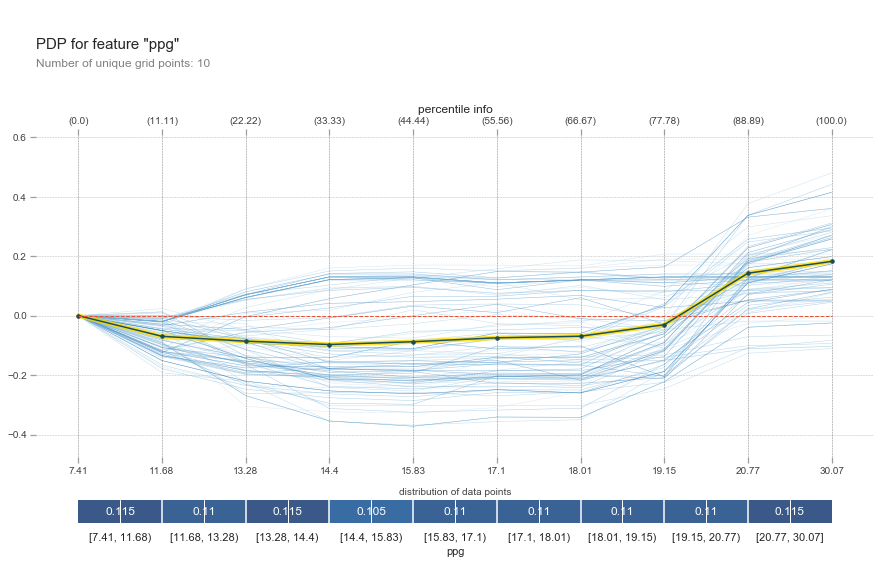

In [29]:
plot_pdp(rf, "ppg")

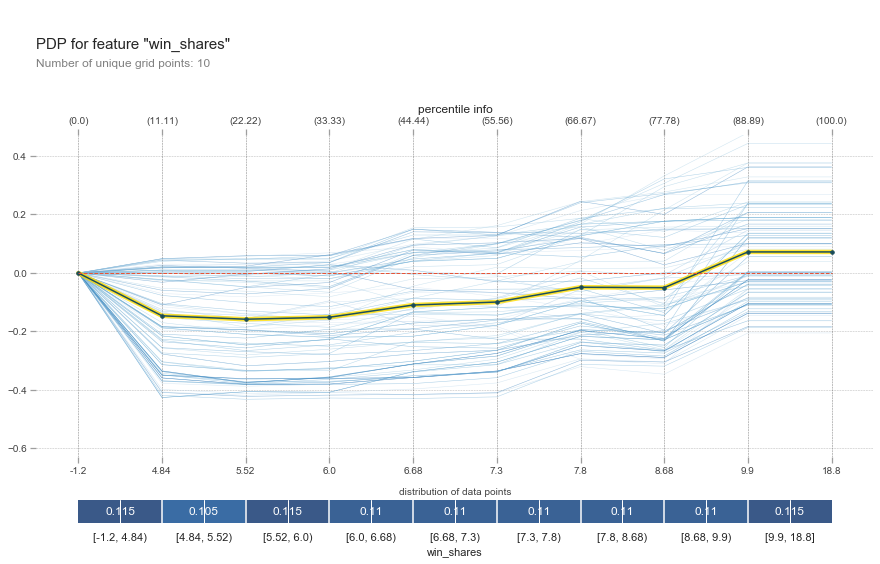

In [30]:
plot_pdp(rf, "win_shares")

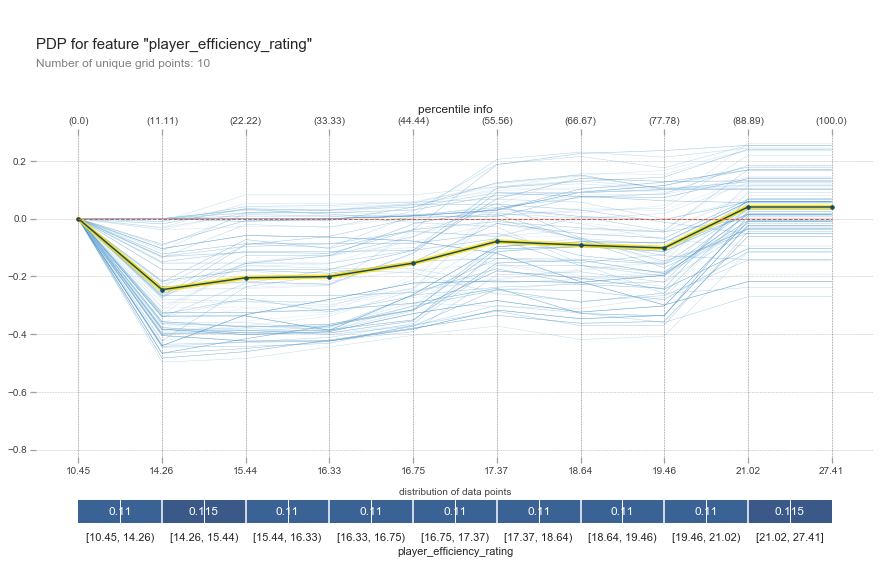

In [31]:
plot_pdp(rf, "player_efficiency_rating")

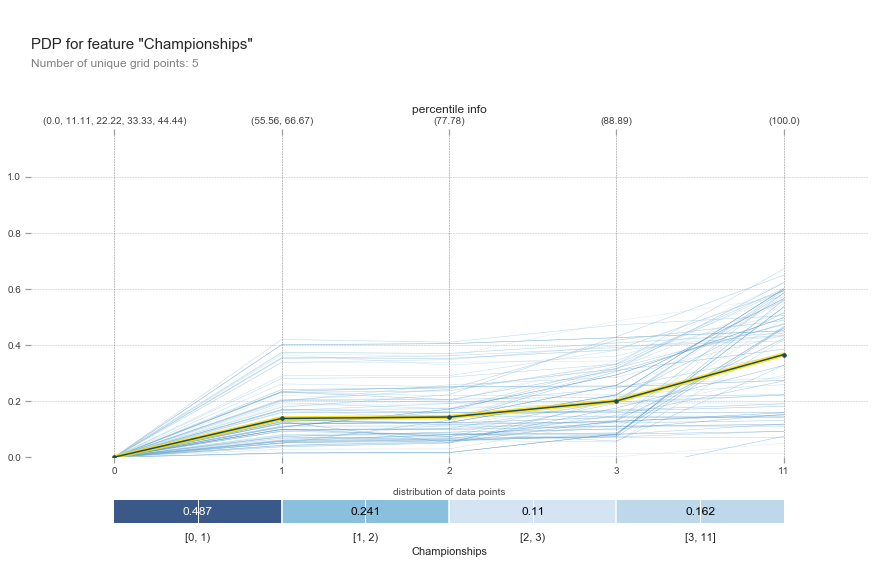

In [32]:
plot_pdp(rf, "Championships")

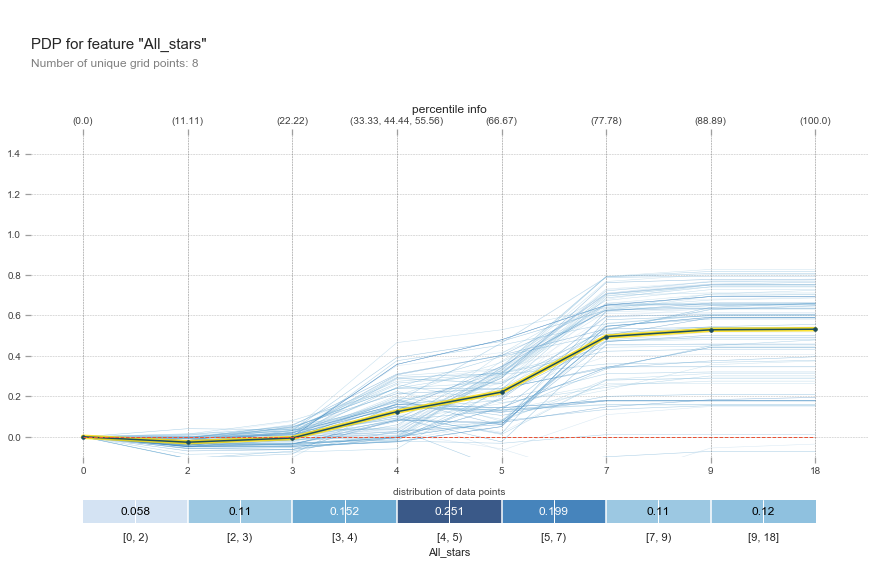

In [33]:
plot_pdp(rf, "All_stars")

Although some of the plots have small initial dips, they all increase in the long run. So we can have confidence that there isn't anything fishy going on.

### Combining Estimators

Now we'll see if we can get even better results by average the outputs of our two estimators.

In [34]:
def get_predictions(model, features):
    train_proba = model.predict_proba(X_trn[features])[:, 1]
    valid_proba = model.predict_proba(X_val[features])[:, 1]
    
    return train_proba, valid_proba

In [35]:
lr_probas = get_predictions(lr_pipe, rfe_features_keep)
rf_probas = get_predictions(rf, best_features)

train_probability = (lr_probas[0] + rf_probas[0]) / 2
train_pred = train_probability > 0.5

valid_probability = (lr_probas[1] + rf_probas[1]) / 2
valid_pred = valid_probability > 0.5

acc = (accuracy_score(y_trn, train_pred), 
       accuracy_score(y_val, valid_pred))

losses = (brier_score_loss(y_trn, train_probability),
         brier_score_loss(y_val, valid_pred))

print(acc, losses)

(0.9476439790575916, 0.9666666666666667) (0.06099515571971145, 0.03333333333333333)


In [36]:
X_test = test[features]
y_test = test["hof"].astype(int)

def test_model(model, features):
    proba = model.predict_proba(test[features])[:, 1]
    pred = (proba > 0.5).astype(int)
    
    acc = accuracy_score(y_test, pred)
    loss = brier_score_loss(y_test, proba)
    
    return proba, pred

In [37]:
df = train.append(valid, ignore_index = True)

X, y = df.drop("hof", axis=1), df["hof"]

lr_pipe.fit(X[rfe_features_keep], y);
rf.fit(X[best_features], y);

In [38]:
lr_test = test_model(lr_pipe, rfe_features_keep)
rf_test = test_model(rf, best_features)

print("Ensemble: ", sep="")
test_probability = (lr_test[0] + rf_test[0]) / 2
test_prediction = test_probability > 0.5

acc = accuracy_score(y_test, test_prediction)
loss = brier_score_loss(y_test, test_probability)

print(acc, loss)

Ensemble: 
0.8571428571428571 0.1364061293309076


Even though we did take precautions it looks like our model may have overfit a bit. Without much data, it's very hard to construct a reliable validation set to prevent this from hapening.

### Model Visualization

Lastly, let's visualize how well our model performed on the test and training sets.

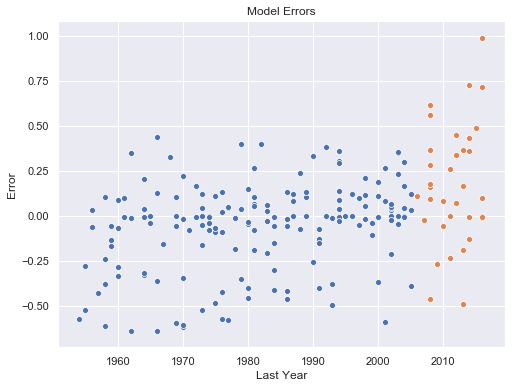

In [39]:
train_diff = ((lr_pipe.predict_proba(X[rfe_features_keep])[:, 1] 
               + rf.predict_proba(X[rf_features])[:, 1]) / 2) - y
test_diff = test_probability - y_test

#Remove observations where Last Year is missing
rem_index =  np.where(X["LastYear"] == 0)[0]

last_year = np.delete(np.array(X["LastYear"]), rem_index)
train_diff = np.delete(np.array(train_diff), rem_index)

plt.figure(figsize=(8, 6));
sns.scatterplot(x=last_year,y=train_diff).set_title("Model Errors");
sns.scatterplot(test["LastYear"], test_diff);
plt.xlabel("Last Year");
plt.ylabel("Error");

We can see that our model clearly did much better on the training set than the test set. However, one thing we may notice is that most of the big errors in the test set are players that the model is confident will make the hall of fame.

Moreover, the biggest errors seem to be the very recently eligible players. This may suggest to us that the model may not actually be wrong, and some these players may actually make the hall of fame, even though they haven't made it yet.

In [49]:
test["Probability"] = test_probability
test["Error"] = abs(test_diff).apply(lambda x: '%.4f' % x)

test.sort_values("Error", ascending=False)[["Name", "Probability", "Error", "hof"]]

,Name,Probability,Error,hof
id,,,,
boshch01,Chris Bosh,0.989689,0.9897,0
billuch01,Chauncey Billups,0.727935,0.7279,0
stoudam01,Amar'e Stoudemire,0.716840,0.7168,0
horryro01,Robert Horry,0.617287,0.6173,0
webbech01,Chris Webber,0.561949,0.5619,0
hillgr01,Grant Hill,0.511938,0.4881,1
mariosh01,Shawn Marion,0.487893,0.4879,0
mournal01,Alonzo Mourning,0.543043,0.4570,1
wallabe01,Ben Wallace,0.452180,0.4522,0
